In [11]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas_ta as ta
from arch import arch_model
import numpy as np
from ib_insync import *
from collections import deque
from enum import Enum
import datetime
import logging
import math
util.startLoop()

In [ ]:
"""start here
TODO's:
1) get list of simple trending strategies (have MA, finish EMA, maybe couple more) -> Done
2) combine them? or just use one? look at the Carver example on Github -> for now, just use EMA

3) Why isn't plot equity curve working? think bc dataframe is only getting columns for relevant asset
after a trade is requested


3) Sketch out architecture w/ class diagrams and objects. Account, strategy, contracts, etc. Last time
I was working on backtesting and displaying a dataframe showing full record of transactions. Think I 
should spend some upfront time thinking about architecture. 

3) back to actual trading - how to run for >1 contracts? may require multiple threads
4) run live (paper trading) in cloud 
5) Strategies should be objects not just parameters, would make it easier to set multiple strategies at once
including the same strategy (eg EMA) with multiple parameters so could track momentum over various scales simultaneously
6) annotate charts



"""

In [12]:
"""logging parameters"""
today = datetime.datetime.today().date()
logging.basicConfig(level = logging.INFO,
                   filename = 'algo_log_'+str(today)+'_.log',
                   filemode='w')


In [13]:

contract_dict = {'Stock':Stock, 'Crypto':Crypto}

class Algo():
    def __init__(self, client, addr, port, client_id):
        self.client = client
        self.addr = addr
        self.port = port
        self.client_id = client_id
        
        self.client.connect(addr, port, client_id)
        
    def SetPaperBalances(self):
        self.USD_balance = 1000
        self.BTC_balance = 0
        
        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
    
    def GetContract(self, contract_type, ticker, exchange, currency):
        return contract_dict[contract_type](ticker, exchange, currency)
    
    def GetHistoricalData(self, contract, duration='1 D', bar_size='1 hour'):
        bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr=duration,
                                    barSizeSetting=bar_size, whatToShow='MIDPOINT', useRTH=True)
        return bars
    
    def BuildEMA(self, slow_period, fast_period):
        """using deques instead of dataframes"""
        self.slow_ema = deque(maxlen=slow_period)
        self.fast_ema = deque(maxlen=fast_period)
        
        """need to employ scanner to pull in data"""
        
           
    def GetDMI(self, df):
        df_adx = ta.adx(high=df['high'], low=df['low'], close=df['close'])
        df['ADX'] = df_adx['ADX_14']
        df['DMN'] = df_adx['DMN_14']
        df['DMP'] = df_adx['DMP_14']
        df['DM_diff'] = df['DMP'] > df['DMN']
        return df
        
    
    
    def GetMovingAverages(self, df, low, high, plot=True):
#         print('length:', len(df))
        df_MA = df.copy()
        if len(df) < high:
            return
#         display('in mov avg fn', df_MA)
        
        df_MA[str(low)+'_average'] = df.close.rolling(low).mean()
        df_MA[str(high)+'_average'] = df.close.rolling(high).mean()
#         df_MA.dropna(inplace=True)
        df_MA['MA_diff'] = df_MA[str(high)+'_average'] > df_MA[str(low)+'_average']
        
        if plot:
            df_MA['close'].plot(legend=True)
            df_MA[str(low)+'_average'].plot(legend=True)
            df_MA[str(high)+'_average'].plot(legend=True)
        
#         display('end of mov avg', df_MA)
        return df_MA
    
    
    def PlacePaperOrder(self, order_type, price=None, quantity=None, date=None):
        print('placing order:', order_type)

        if order_type=='sell':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance -= quantity
            self.USD_balance += quantity * price
            

        elif order_type=='buy':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance += quantity
            self.USD_balance -= quantity * price

        else:
            return 


        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
        account_balance = self.USD_balance + self.BTC_balance * price
        print('Account balance: {}\n'.format(account_balance))       

    def RunDMI(self, df, ADX_MIN=20):
        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['DM_diff']
            else:
                if (row[1]['ADX'] >= ADX_MIN):
                    if row[1]['DM_diff'] == sentiment:
                        self.PlacePaperOrder('no change')
                    else:
                        if row[1]['DM_diff']:
                            self.PlacePaperOrder('buy',row[1]['close'],1, row[1]['date'])
                        else:
                            self.PlacePaperOrder('sell', row[1]['close'],1, row[1]['date'])
                    sentiment = row[1]['DM_diff']
                else: continue                                     
                        
    
    def RunStrategy(self, df):   

        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['MA_diff']
            else:
                if row[1]['MA_diff'] == sentiment:
                    self.PlacePaperOrder('no change')
                else:
                    if row[1]['MA_diff']:
                        self.PlacePaperOrder('sell',row[1]['close'],1)
                    else:
                        self.PlacePaperOrder('buy', row[1]['close'],1)
                    sentiment = row[1]['MA_diff']


def Main(client_id):
    
    ib = IB()
    algo = Algo(ib, '127.0.0.1', 7497, client_id=client_id)
    
    contract = algo.GetContract('Crypto','BTC', 'PAXOS', 'USD')
    
    bars = algo.GetHistoricalData(contract, '180 D', '1 day')
    
    df = util.df(bars)
    
    algo.SetPaperBalances()
    
#     df_MA =  algo.GetMovingAverages(df, 10, 30, True)
    df_DMI = algo.GetDMI(df)
    
#     algo.RunStrategy(df_MA)
    algo.RunDMI(df_DMI)
    
    print('USD balance: {}'.format(algo.USD_balance))
    print('BTC balance: {}'.format(algo.BTC_balance))

    account_value = algo.USD_balance + algo.BTC_balance * bars[-1].close
    print('Account value: {}'.format(account_value))
    
    

In [49]:
class Account():
    def __init__(self, USD_balance: int, BTC_balance: int, BTC_price: float = None):
        self.USD_balance = USD_balance
        self.BTC_balance = BTC_balance
        self.BTC_price = BTC_price                 
#         self.df_account = pd.DataFrame(columns=['Date', 'USD', 'BTC', 'Account Value', 'BTC Px'])
        self.df_account = pd.DataFrame(columns=['Date', 'USD', 'Account Value'])
        self.log = dict()
        self.contracts = dict() #{contract: quantity}
    
    
#        row_dict = self.contracts.copy()
        
#         total = self.USD_balance
#         for contract, quantities in self.contracts.items():
#             total += quantities * 5
        
     
    
    
    def __call__(self):
        return self.returnBalance()
        
    def __repr__(self):
        return 'USD balance: '+ str(self.USD_balance) + '\nBTC balance: ' + str(self.BTC_balance) + '\nAccount Value: '+str(self.USD_balance + self.BTC_balance * self.BTC_price) + '\nBTC Price:' + str(self.BTC_price)
        
        
    def updateBTCPrice(self, BTC_price: float):
        self.BTC_price = BTC_price
        
    def closePosition(self):
        self.BTC_balance = 0
        self.USD_balance -= self.BTC_balance * self.BTC_price
        
    def trade(self, contract, signal: Signal, quantity: int, date: datetime, price): #-> order:    
        print('trading '+contract.symbol)
        self.log[str(date)] = str(signal) + str(quantity)
#         logging.info("%s, %s @, %s" %(signal, quantity))
        
        #get last price for contract
#         self.price = 5
        
        if contract.symbol not in self.contracts.keys():
            self.contracts[contract.symbol] = 0
            self.df_account[contract.symbol] = ''
            self.df_account[contract.symbol+' Px'] = np.nan
            
        
        #exit current position if there is one 
        else:
            self.USD_balance += self.contracts[contract.symbol] * price
            self.contracts[contract.symbol] = 0
            
        direction = 1 if signal==Signal.BUY else -1
        
        self.contracts[contract.symbol] += direction * quantity
        self.USD_balance -= direction * quantity * price
        
        order_type = 'BUY' if signal==Signal.BUY else 'SELL'
        
        order = LimitOrder(order_type, quantity, round(price, 0),
                           tif='GTC')
        return order     
        
        
        
    
    def tradeBTC(self, signal: Signal, quantity: int, date: datetime): #-> order:
        
        self.log[str(date)] = str(signal) + str(quantity)
        logging.info("%s, %s @, %s" %(signal, quantity, self.BTC_price))
        
        #first exit current position if there is one 
        if self.BTC_balance != 0:
            self.USD_balance += self.BTC_balance * self.BTC_price
            self.BTC_balance = 0
        
        direction = 1 if signal==Signal.BUY else -1
        
        self.BTC_balance += direction * quantity
        self.USD_balance -= direction * quantity * self.BTC_price
        
        order_type = 'BUY' if signal==Signal.BUY else 'SELL'
        
        order = LimitOrder(order_type, quantity, round(self.BTC_price, 0),
                           tif='GTC')
        return order 
        
#         self.updateBalance([date, self.USD_balance, self.BTC_balance, self.total])
                
    def updateBalance(self, date, close):
        #get prices, add price function
        row_dict = self.contracts.copy()
        
        total = self.USD_balance
        for ticker, quantities in self.contracts.items():
            price = close
            total += quantities * close
            row_dict[ticker+' Px'] = close
        
        row_dict['Account Value'] = total
        row_dict['Date'] = date
        row_dict['USD'] = self.USD_balance               
        
        self.df_account = self.df_account.append(row_dict, ignore_index=True)
#         display(self.df_account)
        
        
        
        
                    

    #         total = self.USD_balance + self.BTC_balance * self.price

        # add row
        
        

#         self.df_account.loc[len(self.df_account.index)] = [date, self.USD_balance,
#                                                           self.BTC_balance, total, self.BTC_price]       
        
        
        
        
#         total = self.USD_balance + self.BTC_balance * self.BTC_price
#         self.df_account.loc[len(self.df_account.index)] = [date, self.USD_balance,
#                                                           self.BTC_balance, total, self.BTC_price]       
        
    def returnBalance(self):
        return self.df_account
    
    def plotBalance(self):
        self.df_account.plot(x='Date', y=['Account Value'])
        
        

In [64]:
"""real time updates"""

from collections import deque
import pandas as pd


Sentiment = Enum('Sentiment','BEAR NEUTRAL BULL')
Signal = Enum('Signal','BUY SELL')

strategy_dict = dict()

def AddStrategy(strategy_fn):
    strategy_dict[strategy_fn.__name__] = strategy_fn
    return strategy_fn
  
def LogFunctionCall(fn):
    logging.info(fn.__name__+' called')
    return fn

def PrintFunction(fn):
    print(fn)
#     print(fn.__code__.co_varnames)
    return fn
    


class Strategy():
    def __init__(self, account: Account, ib, client_id: int, contract: Contract,
                 paper_trading: bool = True):
        self.client_id = client_id
        self.ib = ib     
        self.algo = Algo(ib, '127.0.0.1', 7497, client_id=self.client_id)
        self.algo.SetPaperBalances()
        self.contract = contract
#         self.contract = Crypto('BTC', exchange='PAXOS', currency='USD')
        self.account = account
        self.paper_trading=paper_trading
        self.sentiment = dict()
        self.signal = dict()
        self.trades = list()


    
    def onBarUpdate(self, bars, newBar):
        if newBar:
            print('on bar update', bars[-1])
            self.strategy_params['close'] = bars[-1].close 
            self.strategy(**self.strategy_params)    
            self.SignalProcess(self.strategy.__name__, date=bars[-1].time)   
 
    
    def SetSentiment(self, current_sentiment):                 
        print('set sentiment')
        if self.sentiment.get(self.strategy.__name__) is None:
            self.sentiment[self.strategy.__name__] = current_sentiment
            print('first sentiment')
            return

        if self.sentiment[self.strategy.__name__] != current_sentiment:
            print('change in sentiment')
            
            if current_sentiment == Sentiment.BEAR:
                self.signal[self.strategy.__name__] = Signal.SELL               

            elif current_sentiment == Sentiment.BULL:
                self.signal[self.strategy.__name__] = Signal.BUY                        
        else:
            print('no change in sentiment')

                              
        self.sentiment[self.strategy.__name__] = current_sentiment
#         print('ending sentiment:', self.sentiment['EMAverage'])
        
    
    @AddStrategy
    @LogFunctionCall
    def EMAverage(self, smoothing, period, close):
        if not hasattr(self, "SMA_lst"):
            self.SMA_lst = []
        
        self.SMA_lst.append(close)        
        self.account.updateBTCPrice(BTC_price=close)        
        
        if len(self.SMA_lst) < period:            
            return            
        
        k = smoothing / (1 + period)
        
        if len(self.SMA_lst) == period:            
            self.EMA = np.array([])
            self.EMA = np.append(self.EMA,sum(self.SMA_lst[0:period])/period)
            return
        
        new_value = close * k  + self.EMA[-1] * (1 - k)
        self.EMA = np.append(self.EMA, new_value)
        print(self.EMA)
        
                
        print('last value:', self.EMA[-1])
        print('close', close)
        if close < self.EMA[-1]:            
            current_sentiment_EMA = Sentiment.BEAR
            print('bearish')
        elif close > self.EMA[-1]:
            current_sentiment_EMA = Sentiment.BULL
            print('bullish')
        else:
            current_sentiment_EMA = Sentiment.NEUTRAL   
            
        
        self.SetSentiment(current_sentiment_EMA)                       

    
    @AddStrategy
    @LogFunctionCall
    def MovingAverage(self, low, high, close):
        
        if not (hasattr(self, "low_deque") and hasattr(self, "high_deque")):
            low_deque_len, high_deque_len = low, high
            self.low_deque = deque(maxlen=low_deque_len)
            self.high_deque = deque(maxlen=high_deque_len)              

        self.low_deque.append(close)
        self.high_deque.append(close)
        self.account.updateBTCPrice(BTC_price=close)        
        
        if len(self.high_deque) < self.high_deque.maxlen:
            return
        low_avg = sum(self.low_deque)/len(self.low_deque)
        high_avg = sum(self.high_deque)/len(self.high_deque)

        if low_avg < high_avg:
            current_sentiment_MA = Sentiment.BEAR
        elif low_avg > high_avg:
            current_sentiment_MA = Sentiment.BULL
        else:
            current_sentiment_MA = Sentiment.NEUTRAL     
            
        self.SetSentiment(current_sentiment_MA) 
     
        
    @LogFunctionCall
    @PrintFunction
    def SignalProcess(self, *signals, date, close):        
        print('signal dict',self.signal.items())
        signal_list = [values for keys,values in self.signal.items() if keys in signals]
        print('signals', signal_list)        
        
        if len(set(signal_list))==1 and signal_list[0] is not None: #i.e. all signals are the same
            print(date)
            signal = signal_list[0]
            print(str(signal) + ' @ ' + str(self.account.BTC_price))
            order = self.account.trade(self.contract, signal=signal, quantity=1, date=date,
                                       price=close)
            
            if not self.paper_trading:
                self.trades.append(self.ib.placeOrder(self.contract, order))
            
            self.ClearSignals(*signals)                
        
        self.account.updateBalance(date=date, close=close)
        print(self.account)
    
    def ClearSignals(self, *signals):
        for s in signals:
            self.signal[s]=None                  

    def SetStrategy(self, strategy, **kwargs):
        self.strategy = strategy_dict[strategy]
        self.strategy_params = kwargs
        self.strategy_params['self'] = self
        
            
    def RunStrategy(self):             

        bars = ib.reqRealTimeBars(contract=self.contract,
                                  barSize=5,
                                  whatToShow='MIDPOINT',
                                 useRTH=False)
        bars.updateEvent += self.onBarUpdate

        self.ib.sleep(100)
        self.ib.cancelRealTimeBars(bars)        
    
        
    def Backtest(self, duration='360 D', barSize='1 day'):
        self.paper_trading = True
#         display(self.contract)
#         display(self.contract.__dict__)
        bars = ib.reqHistoricalData(
            self.contract, endDateTime='', durationStr=duration,
            barSizeSetting=barSize, whatToShow='MIDPOINT', useRTH=True)     
        
        display(bars)
        df = util.df(bars)        
        display(df)
        for row in df.itertuples(name='bar', index=False):    
            self.strategy_params['close'] = row.close 
            self.strategy(**self.strategy_params)    
            self.SignalProcess(self.strategy.__name__, date=row.date, close=row.close)
            
    def PlotEquityCurve(self, contract_ticker):
        df_plot = self.account.df_account.copy()
        df_plot.dropna(inplace=True)
        fig, axs = plt.subplots(2, figsize=(15,15))        
        date = df_plot['Date']
        axs[0].title.set_text('Account Value')
        axs[1].title.set_text(contract_ticker)
        axs[0].plot(date, df_plot['Account Value'])
        axs[1].plot(date, df_plot[contract_ticker+' Px'])
        plt.show()
        
    def PlotSignal(self, signal_values):
        plt.figure(figsize=(15,15)) 
        self.account.df_account['Signal'] = signal_values
        plt.plot(self.account.df_account['Date'], self.account.df_account['Signal'])
        plt.plot(self.account.df_account['Date'], self.account.df_account['BTC Px'])
        
        
            
   


<function Strategy.SignalProcess at 0x0000024B4D9E79D0>


In [144]:
# contract = Forex('EURUSD')
# contract = Stock('INTC')
contract = Stock('TSLA', 'SMART', 'USD')
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)
# contract = Stock('SPY', 'SMART', 'USD')
# contract = Stock('INTC', 'SMART', 'USD', primaryExchange='ISLAND')

bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='1 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=True,
    formatDate=1)

In [145]:
print(contract)
bars

Stock(symbol='TSLA', exchange='SMART', currency='USD')


[]

In [136]:
bars
Stock?

In [51]:
"""all setting of sentiment done here
        calclates the trading signals and sends that to strategy
        
        use above algo class
        
        """

class Algorithm():
    def __init__(self, indicator: str, contract: Contract):
        pass
        

In [65]:
ib = IB()

# contract1 = Crypto('BTC', exchange='PAXOS', currency='USD')
contract2 = Stock('MSFT', 'SMART', 'USD')
contract2 = Stock('INTC', 'SMART', 'USD', primaryExchange='NASDAQ')
# contract2 = Forex('EURUSD')

account = Account(USD_balance=1000, BTC_balance=0)
S = Strategy(account, ib, 14, contract=contract2, paper_trading=True)

S.SetStrategy('MovingAverage',low=5,high=10)
# S.SetStrategy('EMAverage',smoothing=2, period=20)


# S.RunStrategy()
    
S.Backtest(duration='360 D')


USD balance: 1000
BTC balance: 0


[]

None

AttributeError: 'NoneType' object has no attribute 'itertuples'

In [68]:
# contract2 = Stock('IBM', 'SMART', 'USD')
# contract2 = Forex('EURUSD')

# bars = ib.reqHistoricalData(
#             contract=contract2, endDateTime='', durationStr='10 D',
#             barSizeSetting='1 day', whatToShow='BID', useRTH=False)
# bars

In [11]:

missing = len(S.account.df_account) - len(S.EMA)
S.EMA = np.insert(S.EMA, 0, [0]*missing)



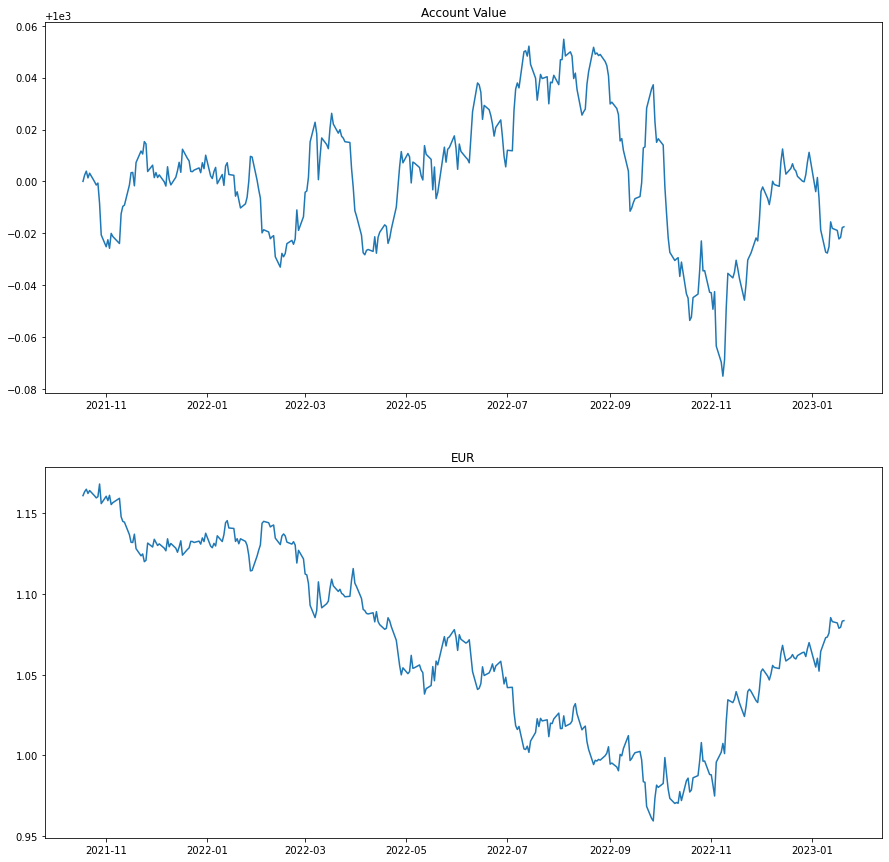

In [53]:
# account.plotBalance()
S.PlotEquityCurve('EUR')
# S.PlotSignal(S.EMA)

# S.account.df_account.head(50)
# S.account.df_account['EURUSD'+' Px']

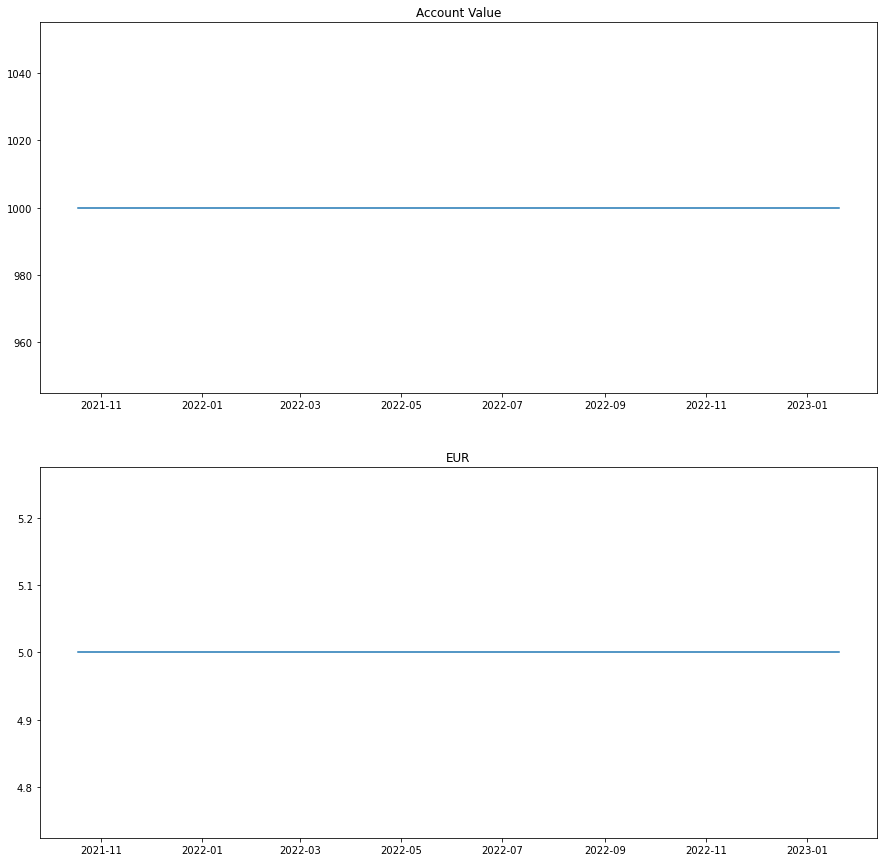

In [36]:
S.account.df_account.head(50)
df_test = S.account.df_account.copy()
df_test.dropna(inplace=True)

fig, axs = plt.subplots(2, figsize=(15,15))        
date = df_test['Date']
axs[0].title.set_text('Account Value')
axs[1].title.set_text('EUR')
axs[0].plot(date, df_test['Account Value'])
axs[1].plot(date, df_test['EUR Px'])

TypeError: 'value' must be an instance of str or bytes, not a int

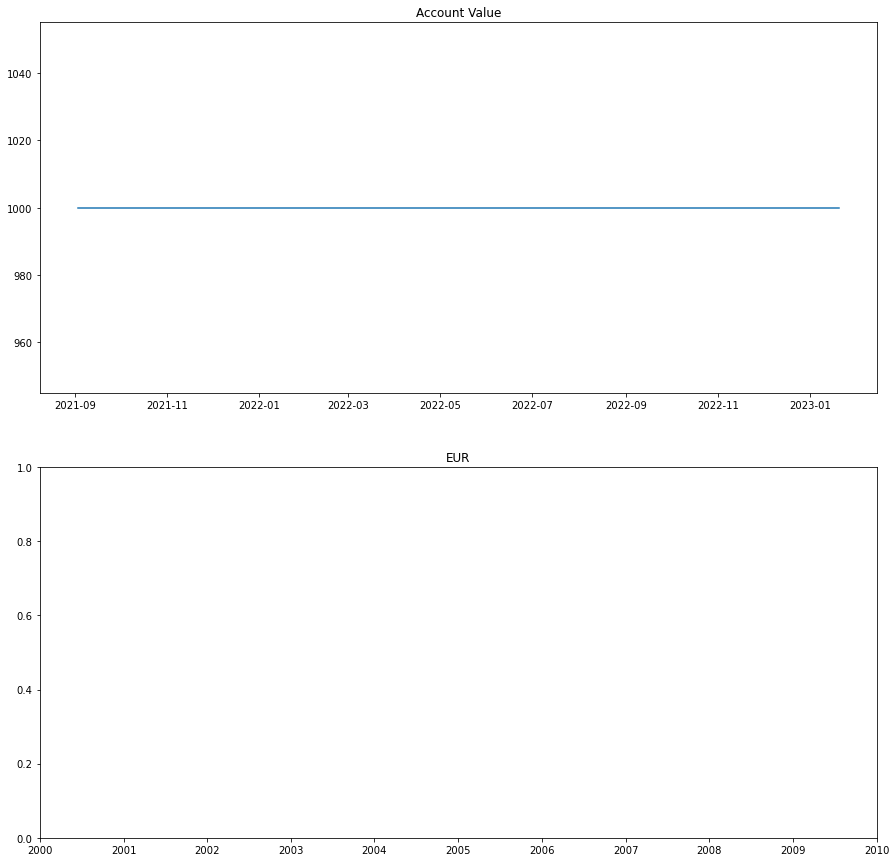

In [21]:
fig, axs = plt.subplots(2, figsize=(15,15))        
date = S.account.df_account['Date']
axs[0].title.set_text('Account Value')
axs[1].title.set_text('EUR')
axs[0].plot(date, S.account.df_account['Account Value'])
axs[1].plot(date, S.account.df_account['EUR Px'])

In [38]:
# S.account.log
S.account.df_account['EUR Px'].iloc[1]

''

In [180]:
datetime.datetime.strptime((list(S.account.log.keys())[0]), '%Y-%m-%d').date()

datetime.date(2021, 10, 1)

TypeError: an integer is required (got type str)

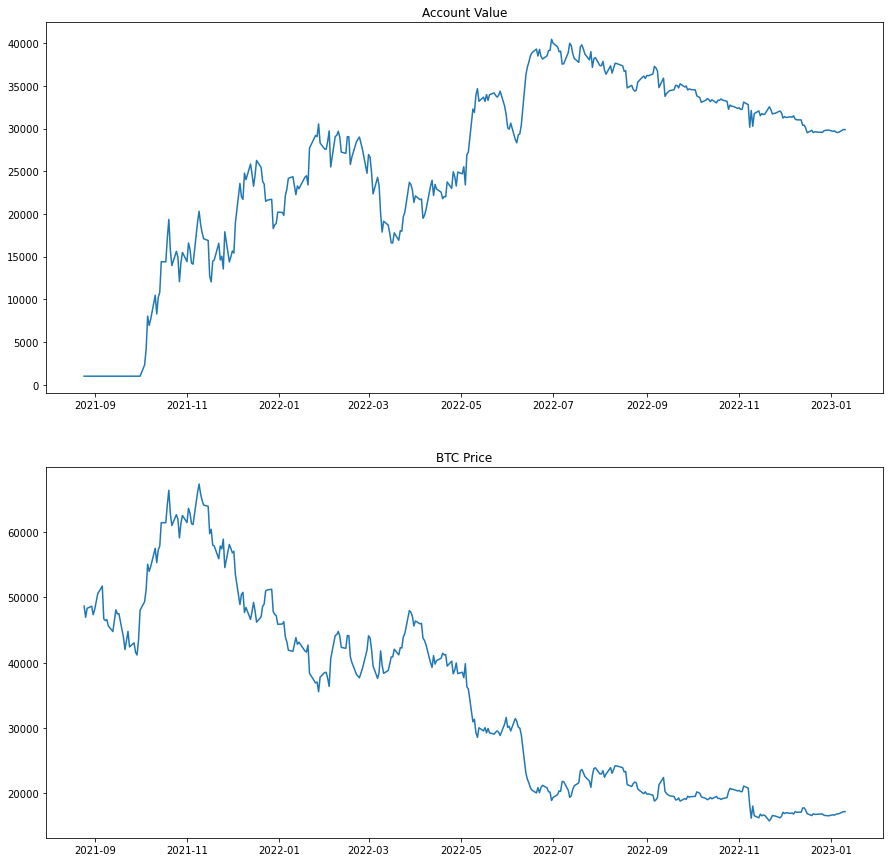

In [183]:
# def PlotEquity(df):
fig, axs = plt.subplots(2, figsize=(15,15))


date = account.df_account['Date']
axs[0].title.set_text('Account Value')
axs[1].title.set_text('BTC Price')
axs[0].plot(date, account.df_account['Account Value'])



# axs[1].annotate('test',xy=(10, 20000))
axs[1].plot(date, account.df_account['BTC Px'])

for d, trade in S.account.log.items():
    axs[1].annotate(trade,(mdates.date2num(datetime.datetime(d),20000)))
    
    
# axs[1].annotate('test',(mdates.date2num(datetime.datetime(2022,1,1)), 20000))

Text(18993.0, 20000, 'test')

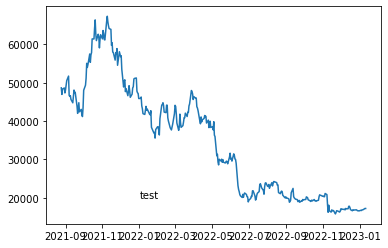

In [163]:
from matplotlib import pyplot as plt, dates as mdates
plt.plot(S.account.df_account['Date'], S.account.df_account['BTC Px'])
plt.annotate('test',(mdates.date2num(datetime.datetime(2022,1,1)), 20000))
# plt.show()


# from matplotlib import pyplot as plt, dates as mdates
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
# x = [dt.datetime(2021, 1, 1), dt.datetime(2021, 1, 2),
#    dt.datetime(2021, 1, 3), dt.datetime(2021, 1, 4)]
# y = [1, 3, 2, 5]
# fig, ax = plt.subplots()
# ax.plot_date(x, y, linestyle='-.')
# ax.annotate('Point', (mdates.date2num(x[1]), y[1]), xytext=(15, 15),
#    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
# fig.autofmt_xdate()
# plt.show()

In [20]:
ib.disconnect()

In [99]:
"""calculate hurst exponent
H < 0.5: mean-reverting
H = 0.5: GBM
H > 0.5: trending
"""
"""https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e#:~:text=To%20calculate%20the%20Hurst%20exponent,versus%20the%20mentioned%20standard%20deviations.
"""

# BTC - short duration - 5 min barsize setting over 7D  - appears mean reverting; half-life was 100 bars
# SPY - short duration - 5 mins over 7d - appears trending 

ib = IB()
ib.connect('127.0.0.1', 7497, 7)
# contract = Crypto('BTC', exchange='PAXOS', currency='USD')
contract = Stock('SPY', 'SMART', currency='USD')
bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr='365 D',
                                    barSizeSetting='8 hours', whatToShow='MIDPOINT', useRTH=False)

In [100]:
df = pd.DataFrame({'close':[i.close for i in bars], 'date':[i.date for i in bars]})
time_series = np.array([i.close for i in bars])
df



close                date
0    426.295 2021-06-25 04:00:00
1    426.885 2021-06-25 12:00:00
2    426.535 2021-06-28 04:00:00
3    427.205 2021-06-28 12:00:00
4    427.995 2021-06-29 04:00:00
..       ...                 ...
829  406.035 2022-12-02 11:00:00
830  405.945 2022-12-02 19:00:00
831  403.360 2022-12-05 04:00:00
832  400.240 2022-12-05 11:00:00
833  400.420 2022-12-05 19:00:00

[834 rows x 2 columns]

In [17]:
"""get returns"""
df['returns'] = df['close'].pct_change()
returns = np.array(df['returns'].dropna())
returns[0:5]

array([-0.01363374, -0.01218101,  0.04000757,  0.04269911,  0.0109376 ])

In [94]:
def GetHurst(time_series, max_lag=5):
    lags = range(2, max_lag)
    
    #variances of lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    
    #hurst exponent is the slope of the log plot
    regression = np.polyfit(x=np.log(lags), y=np.log(tau), deg=1)
    
    return regression[0]
    
    

In [101]:
max_lags = [5, 10, 30, 100, 300]
for i in max_lags:
    print(GetHurst(time_series=time_series, max_lag=i))

0.5010967434731647
0.4991682130560413
0.48189360065690673
0.432548549816401
0.32952678096131766


<AxesSubplot:>

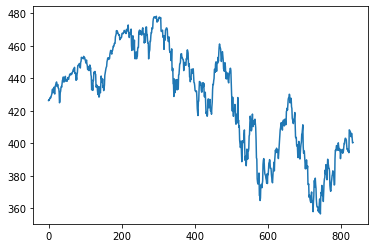

In [103]:
df['close'].plot()

In [18]:
max_lags = [5, 10, 30]
for i in max_lags:
    print(GetHurst(time_series=returns, max_lag=i))

-0.03173854596913254
-0.012352595490179237
-0.006478070055894387


In [47]:
"""testing GBM, trending, and mean reverting"""
sample_size = 1000
scalar = 100

np.random.seed(123)
df_test_data = pd.DataFrame(data={"mean_rev": np.log(np.random.randn(sample_size) + scalar),
                        "gbm": np.log(np.cumsum(np.random.randn(sample_size)) + scalar),
                        "trending": np.log(np.cumsum(np.random.randn(sample_size) + 1) + scalar)})

In [104]:
"""calculate half life"""
lag = 5
# df = pd.DataFrame({'close': df_test_data['mean_rev']})


In [105]:
df['lag'] = df['close'].shift(periods=lag)


In [106]:
df.dropna(inplace = True)
# df.head(10)
# df.tail(20)
X = df['lag']
Y = df['close'] - df['lag']
X = sm.add_constant(X)

In [107]:
model = sm.OLS(Y,X)
results = model.fit()
results.params
print(results.t_test([1,0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            12.6648      3.726      3.399      0.001       5.351      19.979


In [108]:
results.pvalues

const    0.000709
lag      0.000596
dtype: float64

In [109]:
slope = results.params['lag']

In [110]:
half_life = -math.log(2)/slope
half_life

23.115004958980904

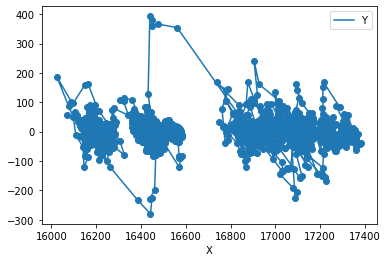

In [90]:
df_ols = pd.DataFrame({'Y': Y, 'X': X['lag']})
df_ols.plot(x='X',y='Y')
plt.scatter(df_ols['X'], df_ols['Y'])

In [ ]:
"""program sequence
1) pick markets - SPY, BTC, commodities, rates, etc
2) determine if trending, mean-reverting, or gbm
 - should focus on longer time intervals to reduce the amount of trades
3) determine indicators for each regime
a) if mean-reverting, calculate half-life for look back window
   - mean-reverting signals?
b) if trending, trending signals ?
 
-

"""

In [ ]:
"""momentum"""

In [ ]:
"""mean reverting"""
def LinearMeanReverting(look_back):
    #lookback can be set to the half-life
    pass

def BuyonGap():
    #buy stocks which gap > 1 std dev below prev day's close
    #only buy those whose opening px is above 20dma of closing prices
    #can do the opposite strategy as well - sellongap
    pass
    
def VIXSandP():
    pass
    

In [48]:
array = np.array([10, 11, 11.5, 10.75, 12, 11.75, 12.25, 14, 16, 17, 15.6, 15.75, 16, 14, 16.5, 17, 17.25, 18, 18.75,20])
period = 5
smoothing = 2
k = smoothing / (1 + period)
EMA = np.array([])
EMA = np.append(EMA,array[0:period].sum()/period)

for i in range(period,len(array)):
    new_value = array[i] * k  + EMA[-1] * (1 - k)
    EMA = np.append(EMA, new_value)


In [50]:
array[0:period]

array([10.  , 11.  , 11.5 , 10.75, 12.  ])

In [51]:
sum([4,3,5])

12